## Семинар 3 "Определение ключевых точек лица"

ФИО:

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


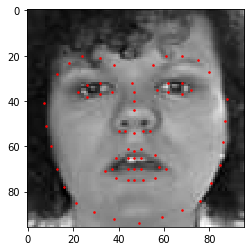

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, Conv2d, ReLU, MaxPool2d, ELU, Dropout, BatchNorm1d, BatchNorm2d
import torch.nn as nn
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')



n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)
# image = Image.open('dataset/train/'+img_name)
# print(im.size)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))
# image = plt.imread('dataset/train/'+img_name)
# print(type(image))
# image = image.reshape(96, 96, -1)

# image = np.expand_dims(image, axis=2)
# print(image.shape)
# plt.imshow(image)

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = plt.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

# class RandomCrop(object):
#     """Random Crop"""
#     def __init__(self, output_size):
# #         assert isinstance(output_size, (int, tuple))
# #         if isinstance(output_size, int):
#         self.output_size = (output_size, output_size)
    
#     def __call__(self, sample):
#         image, landmarks = sample['image'], sample['landmarks']
        
#         return {'image': torch.from_numpy(image),
#                 'landmarks': landmarks}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=transforms.Compose([
                                                ToTensor()])
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

In [7]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, device, loss=MSELoss(), optim=torch.optim.Adam, lr_scheduler_ctor=None, conv=True):
    train_loss_epochs = []
    test_loss_epochs = []
    network.to(device)
    optimizer = optim(network.parameters(), lr=learning_rate)
    
#     lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None
        
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                if conv:
                    X = X.view(-1, 1, 96, 96).type(dtype)
                else:
                    X = X.view(X.shape[0], -1).type(dtype)
                X = X.to(device)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                y = y.to(device)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                if conv:
                    X = X.view(-1, 1, 96, 96).type(dtype)
                else:
                    X = X.view(X.shape[0], -1).type(dtype)
                X = X.to(device)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                y = y.to(device)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            
            test_loss_epochs.append(np.mean(losses))
            print('Epoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            if lr_scheduler is not None:
                lr_scheduler.step(np.mean(losses))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()
    plt.savefig('train_loss.png')

In [8]:
image_size = 96
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(32, 64, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*64, 2 * 68))
    
    def forward(self, x):
#         x = x.view(-1, 1, 96, 96)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [9]:
torch.cuda.is_available()

True

In [10]:
cuda0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', cuda0)

cpu = torch.device('cpu')

Using device: cuda:0


Попробовал для начала сеть прямого распространения

Epoch 0... (Train/Test) MSE: 2403.423/1653.038
Epoch 1... (Train/Test) MSE: 1191.084/798.149
Epoch 2... (Train/Test) MSE: 567.825/371.970
Epoch 3... (Train/Test) MSE: 262.466/169.409
Epoch 4... (Train/Test) MSE: 120.104/78.563
Epoch 5... (Train/Test) MSE: 57.664/40.668
Epoch 6... (Train/Test) MSE: 32.237/26.034
Epoch 7... (Train/Test) MSE: 22.529/20.823
Epoch 8... (Train/Test) MSE: 19.133/19.125
Epoch 9... (Train/Test) MSE: 17.952/18.702


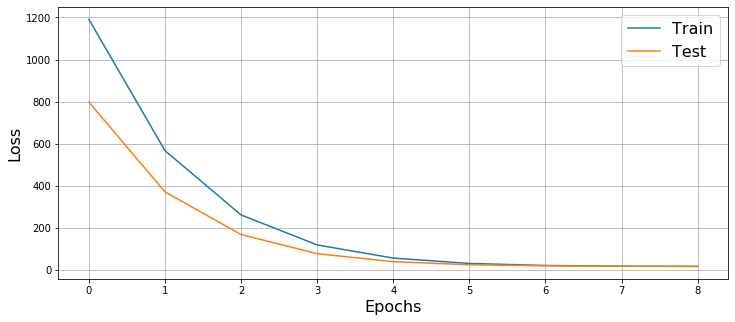

CPU times: user 6.11 s, sys: 844 ms, total: 6.95 s
Wall time: 1min 32s


<Figure size 432x288 with 0 Axes>

In [11]:
%%time
network_s = Sequential(Linear(1 * 96 * 96, 200), Tanh(),
               Linear(200, 2 * 68))

test_s = train(network_s, 10, 1e-3, cuda0, conv=False)

Далее сделал простую архитектуру сверточной нейронной сети с тремя сверточными слоями.

После этого попробовал разными способами улучишь эту архитектуру.

In [12]:
learning_rate = 1e-1
network = ConvClassifier(image_size=96)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
resume = False
if os.path.isfile('ConvCls.pt') and resume:


    checkpoint = torch.load('ConvCls.pt')
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    # model.eval()
    # - or -
    network.train()

Epoch 0... (Train/Test) MSE: 2416.660/144.064
Epoch 1... (Train/Test) MSE: 125.507/120.374
Epoch 2... (Train/Test) MSE: 100.742/92.003
Epoch 3... (Train/Test) MSE: 77.265/80.230
Epoch 4... (Train/Test) MSE: 56.835/48.181
Epoch 5... (Train/Test) MSE: 37.984/33.088
Epoch 6... (Train/Test) MSE: 24.992/24.738
Epoch 7... (Train/Test) MSE: 16.684/20.566
Epoch 8... (Train/Test) MSE: 13.472/12.383
Epoch 9... (Train/Test) MSE: 10.112/11.857


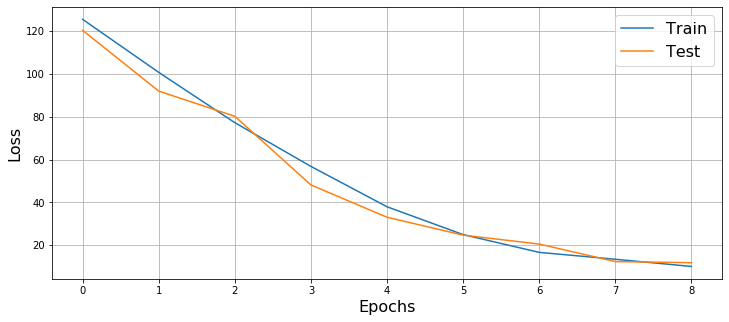

CPU times: user 20.4 s, sys: 4 s, total: 24.4 s
Wall time: 1min 7s


<Figure size 432x288 with 0 Axes>

In [13]:
%%time
train(network, 10, 1e-3, cuda0)

In [14]:
image_size = 96
channels = 1
class ConvClassifier_2(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=8),
                                         nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=16),
                                         nn.ReLU(),
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=32),
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(32, 64, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=64))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*64, 2 * 68))
    
    def forward(self, x):
#         x = x.view(-1, 1, 96, 96)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 0... (Train/Test) MSE: 113.257/15.288
Epoch 1... (Train/Test) MSE: 11.227/12.092
Epoch 2... (Train/Test) MSE: 13.637/11.841
Epoch 3... (Train/Test) MSE: 9.580/14.834
Epoch 4... (Train/Test) MSE: 7.522/12.404
Epoch 5... (Train/Test) MSE: 7.620/8.443
Epoch 6... (Train/Test) MSE: 5.564/9.458
Epoch 7... (Train/Test) MSE: 4.110/7.852
Epoch 8... (Train/Test) MSE: 3.484/8.737
Epoch 9... (Train/Test) MSE: 4.685/24.799


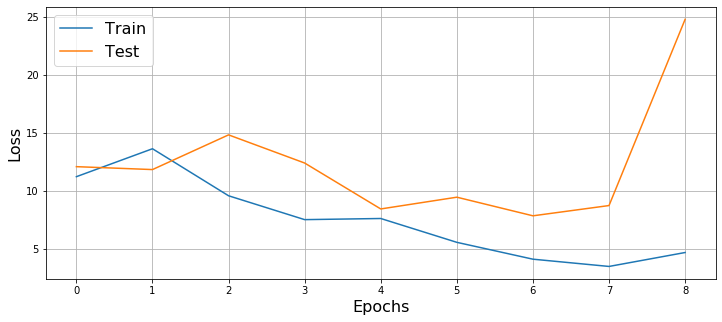

CPU times: user 24 s, sys: 4.88 s, total: 28.8 s
Wall time: 42.6 s


<Figure size 432x288 with 0 Axes>

In [15]:
%%time
network_2 = ConvClassifier_2(image_size=96)
train(network_2, 10, 1e-3, cuda0, lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True))

In [16]:
class ConvClassifier_3(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=8),
                                         nn.Tanh(), 
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=16),
                                         nn.Tanh(),
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=32),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(32, 64, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=64))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*64, 2 * 68))
    
    def forward(self, x):
#         x = x.view(-1, 1, 96, 96)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 0... (Train/Test) MSE: 112.007/15.591
Epoch 1... (Train/Test) MSE: 12.255/11.037
Epoch 2... (Train/Test) MSE: 11.352/11.174
Epoch 3... (Train/Test) MSE: 11.307/11.124
Epoch 4... (Train/Test) MSE: 7.951/11.428
Epoch 5... (Train/Test) MSE: 6.525/11.026
Epoch 6... (Train/Test) MSE: 8.535/11.170
Epoch 7... (Train/Test) MSE: 5.460/15.593
Epoch 8... (Train/Test) MSE: 6.775/12.459
Epoch 9... (Train/Test) MSE: 5.684/10.851
Epoch 10... (Train/Test) MSE: 4.339/10.392
Epoch 11... (Train/Test) MSE: 4.367/10.151
Epoch 12... (Train/Test) MSE: 3.506/8.291
Epoch 13... (Train/Test) MSE: 3.402/14.256
Epoch 14... (Train/Test) MSE: 3.744/10.449
Epoch 15... (Train/Test) MSE: 2.992/9.166
Epoch 16... (Train/Test) MSE: 2.917/10.563
Epoch 17... (Train/Test) MSE: 3.125/9.737
Epoch 18... (Train/Test) MSE: 3.036/9.347
Epoch    18: reducing learning rate of group 0 to 5.0000e-04.
Epoch 19... (Train/Test) MSE: 1.448/7.707
Epoch 20... (Train/Test) MSE: 0.895/7.459
Epoch 21... (Train/Test) MSE: 0.746/7.539
Epoc

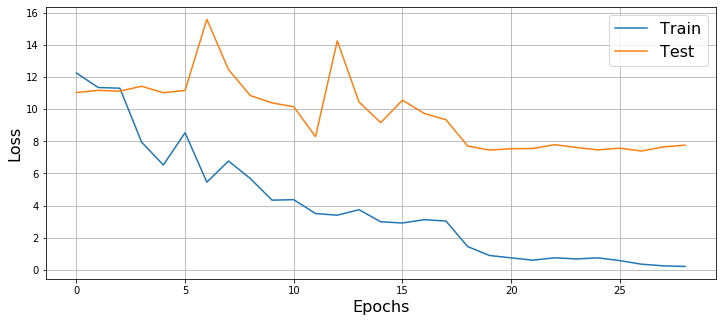

CPU times: user 1min 7s, sys: 13.4 s, total: 1min 21s
Wall time: 3min 36s


<Figure size 432x288 with 0 Axes>

In [17]:
%%time
network_3 = ConvClassifier_3(image_size=96)
train(network_3, 30, 1e-3, cuda0, lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True))

In [18]:
class ConvClassifier_4(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_4, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=8),
                                         nn.Tanh(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=16),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=32),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(32, 64, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=64), 
                                         nn.Tanh())
        self.linear_layers = nn.Sequential(nn.Linear(image_size//8*image_size//8*64, 2 * 68))
        nn.init.kaiming_normal(self.conv_layers[0].weight)
        nn.init.kaiming_normal(self.conv_layers[4].weight)
        nn.init.kaiming_normal(self.conv_layers[8].weight)
        nn.init.kaiming_normal(self.conv_layers[12].weight)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 0... (Train/Test) MSE: 436.480/17.606
Epoch 1... (Train/Test) MSE: 13.024/11.748
Epoch 2... (Train/Test) MSE: 9.435/9.674
Epoch 3... (Train/Test) MSE: 7.882/8.423
Epoch 4... (Train/Test) MSE: 7.079/7.674
Epoch 5... (Train/Test) MSE: 6.577/7.542
Epoch 6... (Train/Test) MSE: 6.040/7.099
Epoch 7... (Train/Test) MSE: 5.682/6.587
Epoch 8... (Train/Test) MSE: 5.448/6.401
Epoch 9... (Train/Test) MSE: 5.117/6.270
Epoch 10... (Train/Test) MSE: 4.988/5.951
Epoch 11... (Train/Test) MSE: 4.703/5.807
Epoch 12... (Train/Test) MSE: 4.486/5.582
Epoch 13... (Train/Test) MSE: 4.363/5.645
Epoch 14... (Train/Test) MSE: 4.203/5.469
Epoch 15... (Train/Test) MSE: 4.035/5.606
Epoch 16... (Train/Test) MSE: 3.889/5.409
Epoch 17... (Train/Test) MSE: 3.834/5.179
Epoch 18... (Train/Test) MSE: 3.678/5.171
Epoch 19... (Train/Test) MSE: 3.636/5.119


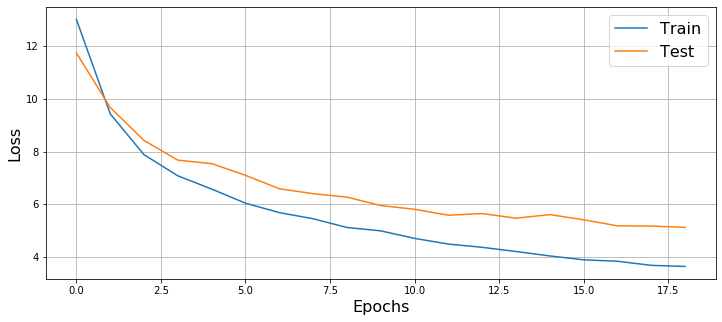

CPU times: user 16.5 s, sys: 2.18 s, total: 18.7 s
Wall time: 1min 26s


<Figure size 432x288 with 0 Axes>

In [19]:
%%time
network_4 = ConvClassifier_4(image_size=96)
train(network_4, 20, 1e-3, cuda0)

In [20]:
class ConvClassifier_5(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_5, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=8),
                                         nn.Tanh(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=16),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(16, 32, 3, padding=1), 
                                         nn.BatchNorm2d(num_features=32),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(32, 64, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//8*image_size//8*64, 2 * 68))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 0... (Train/Test) MSE: 262.620/22.833
Epoch 1... (Train/Test) MSE: 18.119/16.953
Epoch 2... (Train/Test) MSE: 12.916/11.910
Epoch 3... (Train/Test) MSE: 10.492/13.076
Epoch 4... (Train/Test) MSE: 9.490/10.851
Epoch 5... (Train/Test) MSE: 8.774/8.643
Epoch 6... (Train/Test) MSE: 8.059/9.039
Epoch 7... (Train/Test) MSE: 8.796/9.380
Epoch 8... (Train/Test) MSE: 7.202/7.433
Epoch 9... (Train/Test) MSE: 7.519/7.695
Epoch 10... (Train/Test) MSE: 7.293/9.359
Epoch 11... (Train/Test) MSE: 6.733/8.683
Epoch 12... (Train/Test) MSE: 6.661/7.013
Epoch 13... (Train/Test) MSE: 6.296/7.616
Epoch 14... (Train/Test) MSE: 6.468/6.888
Epoch 15... (Train/Test) MSE: 6.197/7.808
Epoch 16... (Train/Test) MSE: 5.953/6.270
Epoch 17... (Train/Test) MSE: 5.858/6.450
Epoch 18... (Train/Test) MSE: 6.039/6.683
Epoch 19... (Train/Test) MSE: 5.558/6.280


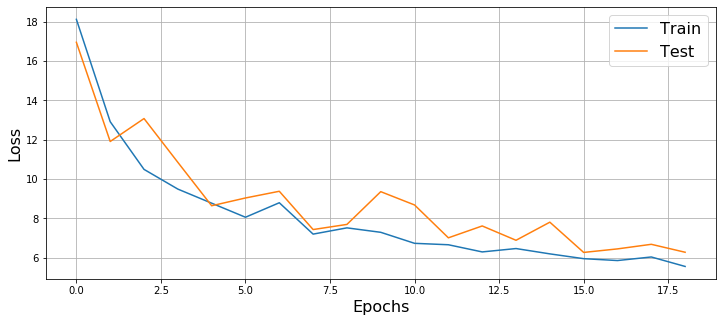

CPU times: user 19.8 s, sys: 2.74 s, total: 22.6 s
Wall time: 3min 15s


<Figure size 432x288 with 0 Axes>

In [21]:
%%time
network_5 = ConvClassifier_5(image_size=96)
train(network_5, 20, 1e-3, cuda0, lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True))

In [22]:
# network_3.to(cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
# batch = next(iter(test_dataloader))
# images_batch = batch['image']
# x = Variable(images_batch.view(-1, 1, 96, 96).type(dtype))
# y_pred = network_3(x)
# y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
# y_pred = y_pred.view(-1, 68, 2)
# y_pred = y_pred.data.numpy()
# show_landmarks_batch(batch, y_pred)